<a href="https://colab.research.google.com/github/GunjanRoy4224/CV-and-NLP/blob/main/NLP_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preprocessing


---


*   okenize text and clean it (lowercase, remove unwanted symbols/punctuation as needed).
*   Build a vocabulary of words → integer indices.
*   Convert each review into a sequence of indices.
*   Pad shorter reviews and truncate longer ones to a fixed length.
*   Split the dataset into training, validation, and test sets.










In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('reviews.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())


Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [2]:
# If sentiment is text (positive/negative), convert to binary
if df['sentiment'].dtype == 'object':
    df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [4]:
# Text Cleaning Function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers (keep letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

In [5]:
# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_text)
print("\nSample cleaned reviews:")
print(df['cleaned_review'].head())


Sample cleaned reviews:
0    one of the other reviewers has mentioned that ...
1    a wonderful little production the filming tech...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: cleaned_review, dtype: object


In [6]:
# Tokenization
def tokenize(text):
    return text.split()

df['tokens'] = df['cleaned_review'].apply(tokenize)

# Build Vocabulary
all_words = []
for tokens in df['tokens']:
    all_words.extend(tokens)

word_counts = Counter(all_words)
print(f"\nTotal unique words: {len(word_counts)}")

vocab_size = 10000  # Limit vocabulary size
most_common = word_counts.most_common(vocab_size - 1)
word2idx = {word: idx + 1 for idx, (word, count) in enumerate(most_common)}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = len(word2idx)  # Unknown words

print(f"Vocabulary size: {len(word2idx)}")



Total unique words: 214430
Vocabulary size: 10001


In [7]:
# Convert tokens to indices
def tokens_to_indices(tokens, word2idx):
    """Convert tokens to integer indices"""
    return [word2idx.get(word, word2idx['<UNK>']) for word in tokens]

df['indices'] = df['tokens'].apply(lambda x: tokens_to_indices(x, word2idx))

In [8]:
# Padding and Truncation
max_length = 200  # Fixed sequence length

def pad_truncate(sequence, max_len):
    """Pad or truncate sequence to max_len"""
    if len(sequence) > max_len:
        return sequence[:max_len]
    else:
        return sequence + [0] * (max_len - len(sequence))

df['padded_indices'] = df['indices'].apply(lambda x: pad_truncate(x, max_length))


In [9]:
# Prepare final data
X = np.array(df['padded_indices'].tolist())
y = np.array(df['sentiment'].values)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split dataset: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"\nTrain set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

# Save preprocessed data
np.save('X_train.npy', X_train)
np.save('X_val.npy', X_val)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_val.npy', y_val)
np.save('y_test.npy', y_test)



X shape: (50000, 200)
y shape: (50000,)

Train set: (35000, 200), (35000,)
Validation set: (7500, 200), (7500,)
Test set: (7500, 200), (7500,)


In [10]:
# Save vocabulary
import pickle
with open('word2idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

print("\nPreprocessing complete! Files saved.")


Preprocessing complete! Files saved.


Model Building

---


Use deep learning libraries such as PyTorch, TensorFlow, or Keras.

Implement an RNN or LSTM model with:
- An Embedding Layer
- One or more RNN/LSTM layers
- A Dense output layer for binary classification (Sigmoid or Softmax activation)

Suggested hyperparameters:
- Embedding dimension: 100–300
- Hidden units: 64–256
- Batch size: 32–128
- Learning rate: 1e-3

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [13]:
# Convert to PyTorch tensors
X_train_tensor = torch.LongTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.LongTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.LongTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)


In [15]:
#Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [16]:
# Define RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.3):
        super(RNNClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers,
                          batch_first=True, dropout=dropout if n_layers > 1 else 0)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, seq_length)

        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # RNN
        output, hidden = self.rnn(embedded)  # output: (batch_size, seq_length, hidden_dim)

        # Take the last hidden state
        last_hidden = output[:, -1, :]  # (batch_size, hidden_dim)

        # Dropout
        dropped = self.dropout(last_hidden)

        # Fully connected
        out = self.fc(dropped)  # (batch_size, output_dim)

        return out.squeeze()


In [17]:
 #Hyperparameters
vocab_size = 10002  # Adjust based on your vocabulary size
embedding_dim = 200
hidden_dim = 128
output_dim = 1
n_layers = 2
dropout = 0.3
learning_rate = 0.001



In [18]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nRNN Model Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cpu

RNN Model Architecture:
RNNClassifier(
  (embedding): Embedding(10002, 200, padding_idx=0)
  (rnn): RNN(200, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Total parameters: 2075793


Training


---


- Use Binary Cross-Entropy (or BCEWithLogitsLoss in PyTorch).
- Optimizer: Adam (recommended).
- Train for multiple epochs (e.g., 5–10).
- Record training and validation loss per epoch.

In [19]:
from tqdm import tqdm

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in tqdm(train_loader, desc="Training"):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()

        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        # Calculate metrics
        total_loss += loss.item()
        predictions = torch.sigmoid(outputs) > 0.5
        correct += (predictions == batch_y).sum().item()
        total += batch_y.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [20]:
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == batch_y).sum().item()
            total += batch_y.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_rnn_model.pt')
            print("✓ Best model saved!")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }
    # Train the RNN model
print("Training RNN Model...")
rnn_history = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10)

# Save training history
import pickle
with open('rnn_history.pkl', 'wb') as f:
    pickle.dump(rnn_history, f)



Training RNN Model...

Epoch 1/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:37<00:00,  5.64it/s]


Train Loss: 0.6940 | Train Acc: 0.5122
Val Loss: 0.6918 | Val Acc: 0.5073
✓ Best model saved!

Epoch 2/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:38<00:00,  5.54it/s]


Train Loss: 0.6929 | Train Acc: 0.5113
Val Loss: 0.6938 | Val Acc: 0.5045

Epoch 3/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:35<00:00,  5.75it/s]


Train Loss: 0.6950 | Train Acc: 0.5006
Val Loss: 0.6932 | Val Acc: 0.4992

Epoch 4/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:35<00:00,  5.76it/s]


Train Loss: 0.6950 | Train Acc: 0.5015
Val Loss: 0.6937 | Val Acc: 0.5044

Epoch 5/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:36<00:00,  5.68it/s]


Train Loss: 0.6944 | Train Acc: 0.5058
Val Loss: 0.6950 | Val Acc: 0.4944

Epoch 6/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:35<00:00,  5.71it/s]


Train Loss: 0.6947 | Train Acc: 0.5062
Val Loss: 0.6955 | Val Acc: 0.5100

Epoch 7/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:35<00:00,  5.72it/s]


Train Loss: 0.6948 | Train Acc: 0.5062
Val Loss: 0.6930 | Val Acc: 0.5093

Epoch 8/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:34<00:00,  5.78it/s]


Train Loss: 0.6947 | Train Acc: 0.5050
Val Loss: 0.6947 | Val Acc: 0.4983

Epoch 9/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:35<00:00,  5.73it/s]


Train Loss: 0.6952 | Train Acc: 0.5036
Val Loss: 0.6932 | Val Acc: 0.5121

Epoch 10/10
--------------------------------------------------


Training: 100%|██████████| 547/547 [01:33<00:00,  5.82it/s]


Train Loss: 0.6952 | Train Acc: 0.5029
Val Loss: 0.6945 | Val Acc: 0.5031


Evaluation


---


- Compute the following metrics on the test set:
  • Accuracy
  • Precision
  • Recall
  • F1-score
- Plot Loss vs Epochs (training + validation).
- (Optional) Visualize a confusion matrix for better understanding of predictions.

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            probabilities = torch.sigmoid(outputs)
            predictions = probabilities > 0.5

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(all_predictions).astype(int)
    labels = np.array(all_labels).astype(int)
    probabilities = np.array(all_probabilities)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': predictions,
        'labels': labels,
        'probabilities': probabilities
    }

    return metrics

def print_metrics(model_name, metrics):
    """Print evaluation metrics"""
    print(f"\n{model_name} Test Set Metrics:")
    print("=" * 50)
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1_score']:.4f}")
    print("=" * 50)

def plot_confusion_matrix(labels, predictions, model_name):
    """Plot confusion matrix"""
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


Evaluating RNN Model...

RNN Test Set Metrics:
Accuracy:  0.5125
Precision: 0.5079
Recall:    0.8077
F1-Score:  0.6236


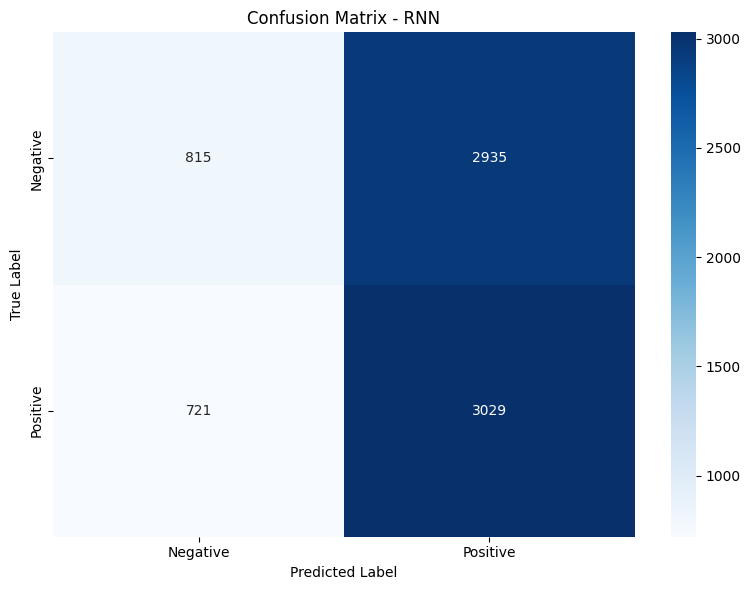

In [28]:
# Evaluate RNN
print("\nEvaluating RNN Model...")
model.load_state_dict(torch.load('best_rnn_model.pt'))
rnn_metrics = evaluate_model(model, test_loader, device)
print_metrics("RNN", rnn_metrics)
plot_confusion_matrix(rnn_metrics['labels'], rnn_metrics['predictions'], "RNN")

Report

---
Include your results and a short explanation of:
- Preprocessing steps
- Model architecture
- Final metrics and insights

Generating comparison plots...


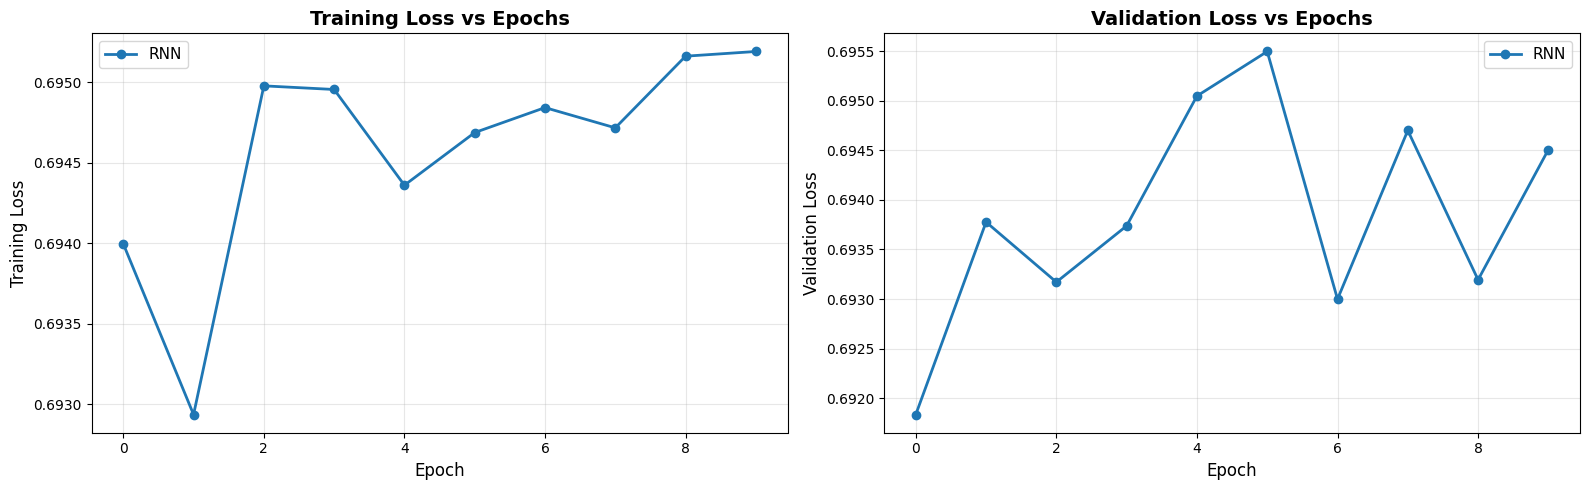

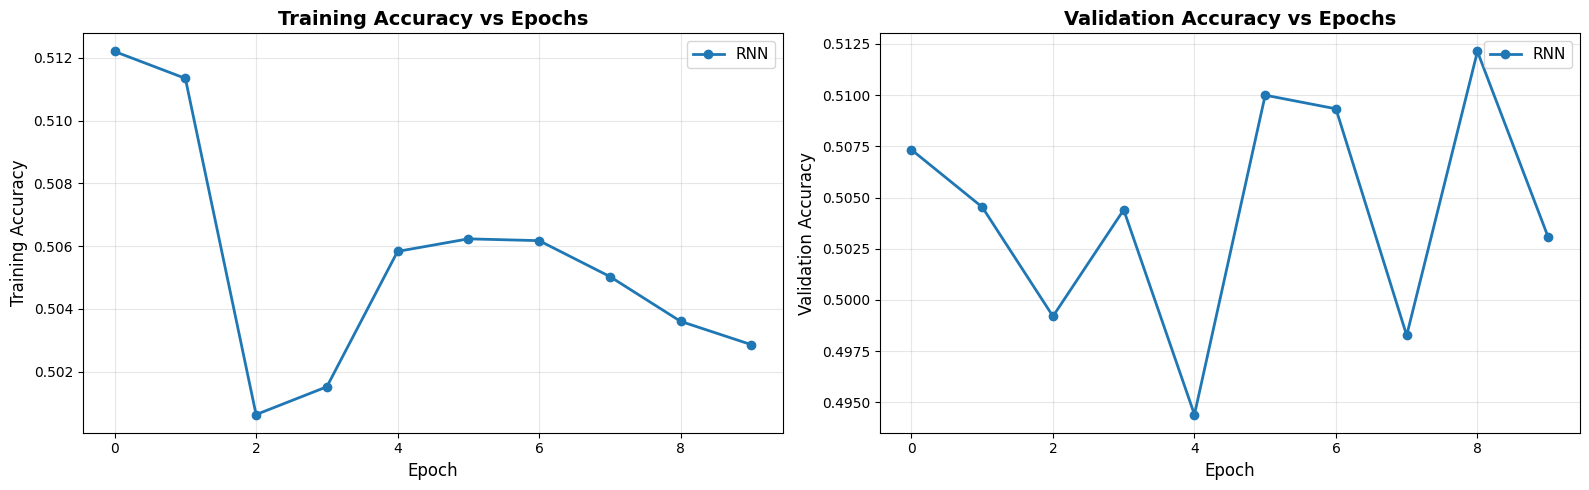


Generating individual model plots...


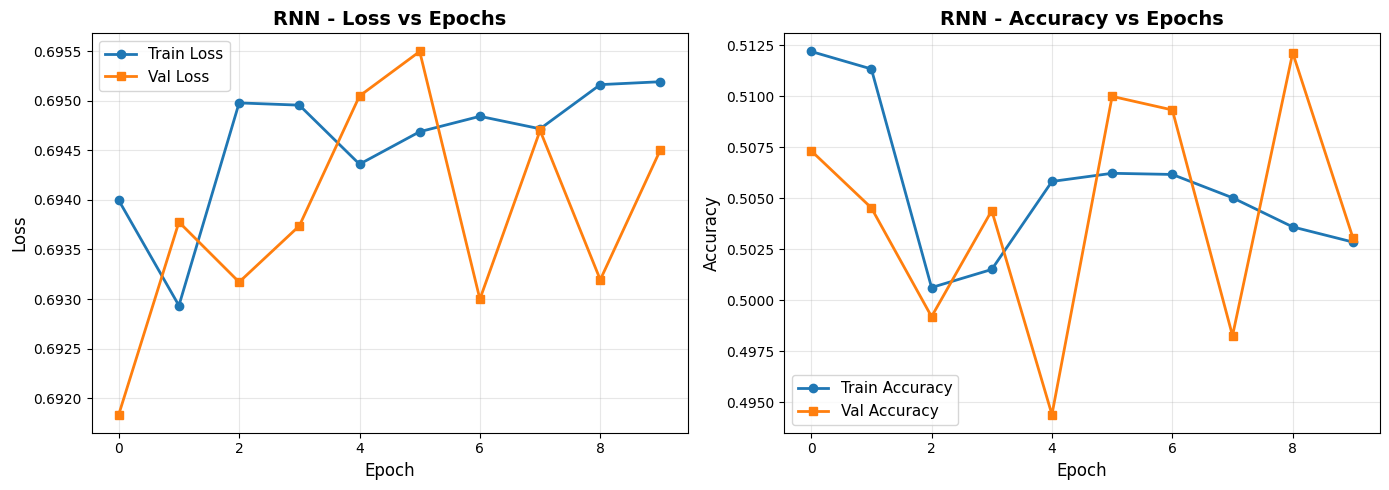

All plots saved successfully!


In [35]:
import matplotlib.pyplot as plt
import pickle

# Load training histories
with open('rnn_history.pkl', 'rb') as f:
    rnn_history = pickle.load(f)

# Plot Loss vs Epochs (All models)
def plot_all_losses():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Training Loss
    axes[0].plot(rnn_history['train_losses'], label='RNN', marker='o', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Training Loss', fontsize=12)
    axes[0].set_title('Training Loss vs Epochs', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Validation Loss
    axes[1].plot(rnn_history['val_losses'], label='RNN', marker='o', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Validation Loss vs Epochs', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('loss_comparison_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot Accuracy vs Epochs
def plot_all_accuracies():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Training Accuracy
    axes[0].plot(rnn_history['train_accuracies'], label='RNN', marker='o', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Training Accuracy', fontsize=12)
    axes[0].set_title('Training Accuracy vs Epochs', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Validation Accuracy
    axes[1].plot(rnn_history['val_accuracies'], label='RNN', marker='o', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Accuracy', fontsize=12)
    axes[1].set_title('Validation Accuracy vs Epochs', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('accuracy_comparison_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()

# Individual model plots
def plot_single_model(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history['train_losses'], label='Train Loss', marker='o', linewidth=2)
    axes[0].plot(history['val_losses'], label='Val Loss', marker='s', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} - Loss vs Epochs', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_accuracies'], label='Train Accuracy', marker='o', linewidth=2)
    axes[1].plot(history['val_accuracies'], label='Val Accuracy', marker='s', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title(f'{model_name} - Accuracy vs Epochs', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate all plots
print("Generating comparison plots...")
plot_all_losses()
plot_all_accuracies()

print("\nGenerating individual model plots...")
plot_single_model(rnn_history, "RNN")

print("All plots saved successfully!")


RNN MODEL PERFORMANCE - TEST SET
Model Accuracy Precision Recall F1-Score
  RNN   0.5125    0.5079 0.8077   0.6236

✓ RNN performance table saved to 'rnn_model_performance.csv'


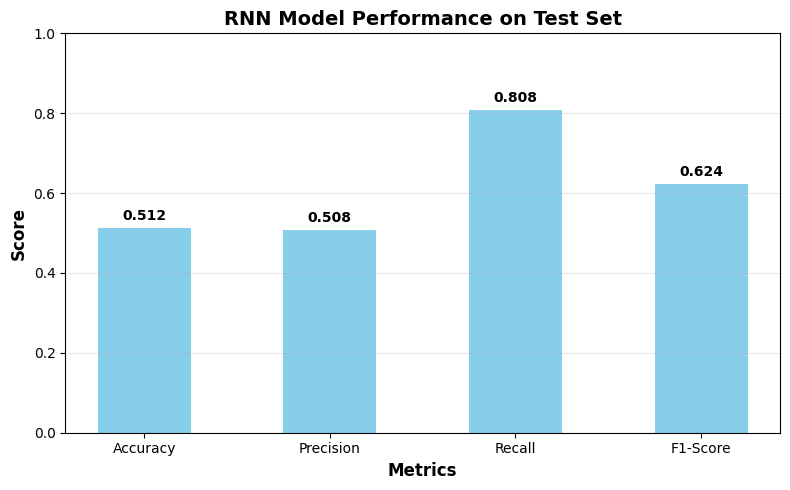

In [34]:
# Create comparison table (RNN only)
def create_comparison_table(rnn_metrics):
    """Create a comparison table for RNN model only"""

    comparison_data = {
        'Model': ['RNN'],
        'Accuracy': [rnn_metrics['accuracy']],
        'Precision': [rnn_metrics['precision']],
        'Recall': [rnn_metrics['recall']],
        'F1-Score': [rnn_metrics['f1_score']]
    }

    df = pd.DataFrame(comparison_data)

    # Format to 4 decimal places
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
        df[col] = df[col].apply(lambda x: f"{x:.4f}")

    return df

# Create and display RNN performance table
comparison_df = create_comparison_table(rnn_metrics)

print("\n" + "="*70)
print("RNN MODEL PERFORMANCE - TEST SET")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Save to CSV
comparison_df.to_csv('rnn_model_performance.csv', index=False)
print("\n✓ RNN performance table saved to 'rnn_model_performance.csv'")

# Visualize RNN metrics
def plot_rnn_metrics(comparison_df):
    """Create a bar chart for RNN model performance"""
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [float(comparison_df.loc[0, metric]) for metric in metrics]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, values, color='skyblue', width=0.5)

    plt.xlabel('Metrics', fontsize=12, fontweight='bold')
    plt.ylabel('Score', fontsize=12, fontweight='bold')
    plt.title('RNN Model Performance on Test Set', fontsize=14, fontweight='bold')
    plt.ylim([0, 1.0])
    plt.grid(True, axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f"{bar.get_height():.3f}", ha='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('rnn_metrics_bar_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_rnn_metrics(comparison_df)
